In [1]:
# Import packages and set up
import numpy as np
from matplotlib import pyplot as plt
import rospy
import cv2
from cv_bridge import CvBridge
from sensor_msgs.msg import CompressedImage, Image
import pyrosbag as prb
import jupyros as jr
from ipywidgets import Video
from sklearn.decomposition import PCA
import pandas as pd
from scipy.signal import butter, filtfilt
import sys
if not '/home/ed/sm_ws/install/' in sys.path:
    sys.path.append('/home/ed/sm_ws/install/')
from cv_bridge.boost.cv_bridge_boost import getCvType
import seaborn as sns
%matplotlib inline

In [2]:
# ROS stuff (roscore needs to be running to proceed)
rospy.init_node('eda', anonymous=True)
br = CvBridge()
therm_pub = rospy.Publisher("thermal/camera/processed", Image, queue_size=1)
color_pub = rospy.Publisher("color/camera/processed", Image, queue_size=1)

# Introduction and Motivation 
The purpose of this project is to build a pipeline to help understand the behavioral patterns of young chickens kept in a backyard coop. The techniques applied here for animal monitoring may be used to improve animal welfare outcomes at commercial farms, which on the one hand have stringent reporting requirements but on the other rely heavily on error-prone and gap-filled manual observation.

# Experimental Description
The data subjects for this experiment are ten young chickens (<3 months old) kept in a backyard coop. There are two coops in the backyard: a larger one with two adult hens and a smaller one with ten young chickens. The smaller coop, where the data for this EDA was collected, affords a mounting point for cameras with a visibility of approximately half of the floor area within the coop. The larger coop where the chickens will eventually live affords a much greater visibility as the cameras are mounted higher up. The young chickens are of similar size to each other and have a wide range of plumage colors and patterns.

# Sensor Setup
The sensor setup consists of a Leopard Imaging fisheye color camera (1920x1080 at ~9FPS) and FLIR Lepton thermal camera (80x60 at ~20FPS). Both cameras were connected to a Jetson Nano and the complete assembly was mounted on the ceiling of a chicken coop pointing downwards. The camera drivers were launched through ROS, and the video streams were saved in a `rosbag` format. This approach assures correct image timestamping and facilitates postprocessing.

(-0.5, 506.5, 676.5, -0.5)

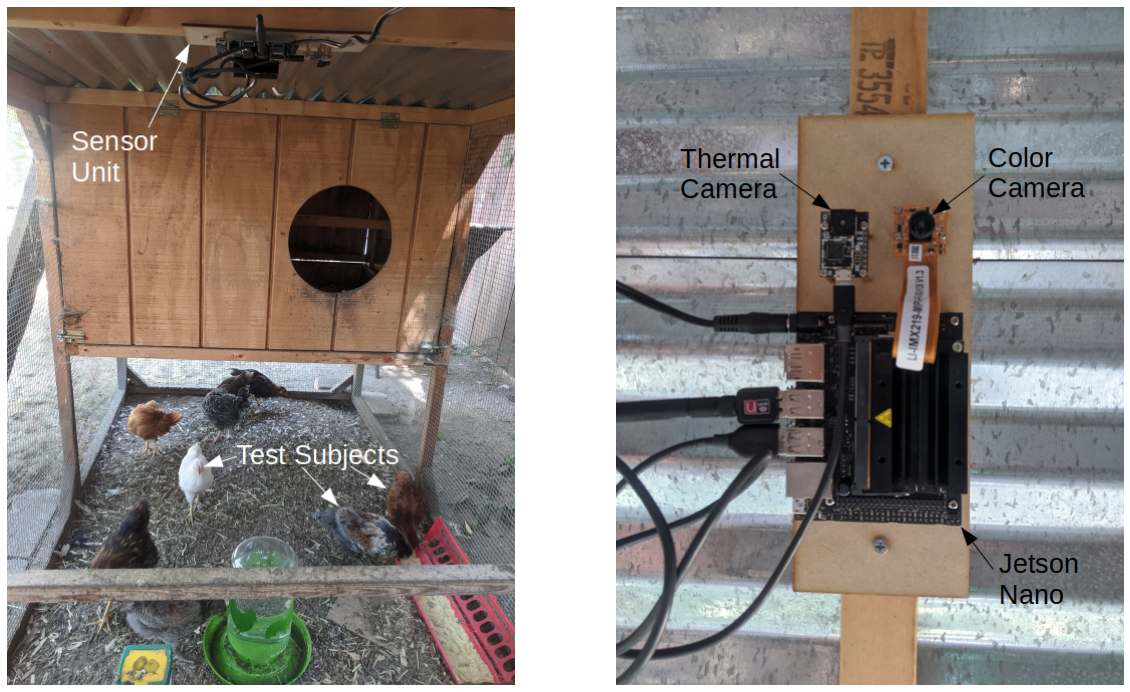

In [117]:
fig, axs = plt.subplots(1, 2, figsize=(20, 20))
axs[0].imshow(plt.imread('assets/coop.png'))
axs[0].axis('off')
axs[1].imshow(plt.imread('assets/board.png'))
axs[1].axis('off')

Images from the color and thermal camera at a given time in the video stream are presented side by side below at the correct scale relative to each other. It is apparent that both the image resolution and aspect ratios are drastically different between the two frames (color: 1920x1080, AR=1.78; thermal: 80x60, AR=1.33). The following figure shows the approximate mapping of the field of view of the thermal frame onto the color frame. The frames are not time-synchronized but the difference between given pairs of frames of around 0.1s is negligible compared to the dynamics of the subjects being observed.

Text(0.5, 1.0, 'Sample frames in the thermal (left) and color (right) spectra')

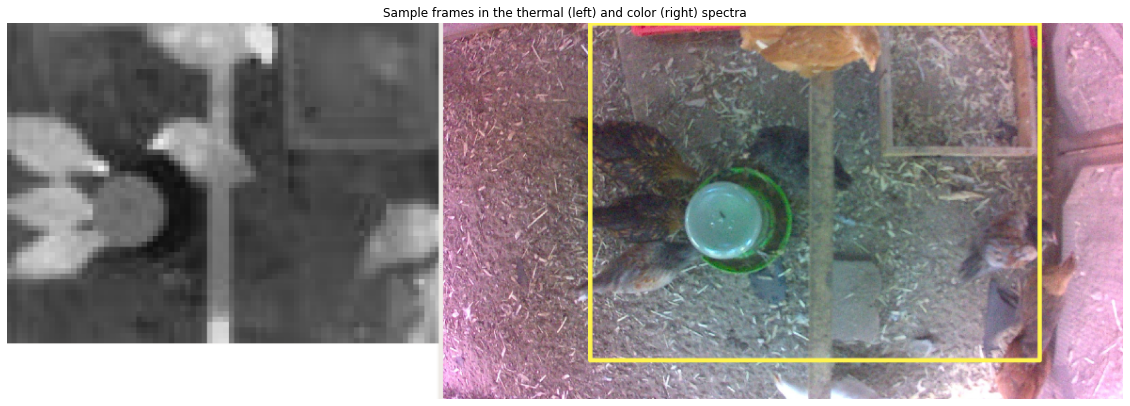

In [123]:
fig, axs = plt.subplots(1, 1, figsize=(20, 20))
axs.imshow(plt.imread('assets/sample_therm_color_bb.png'), )
plt.axis('off')
plt.title('Sample frames in the thermal (left) and color (right) spectra')

A separate notebook is used to calculate the transformation matrix which will enable the conversion between thermal and color pixel spaces.

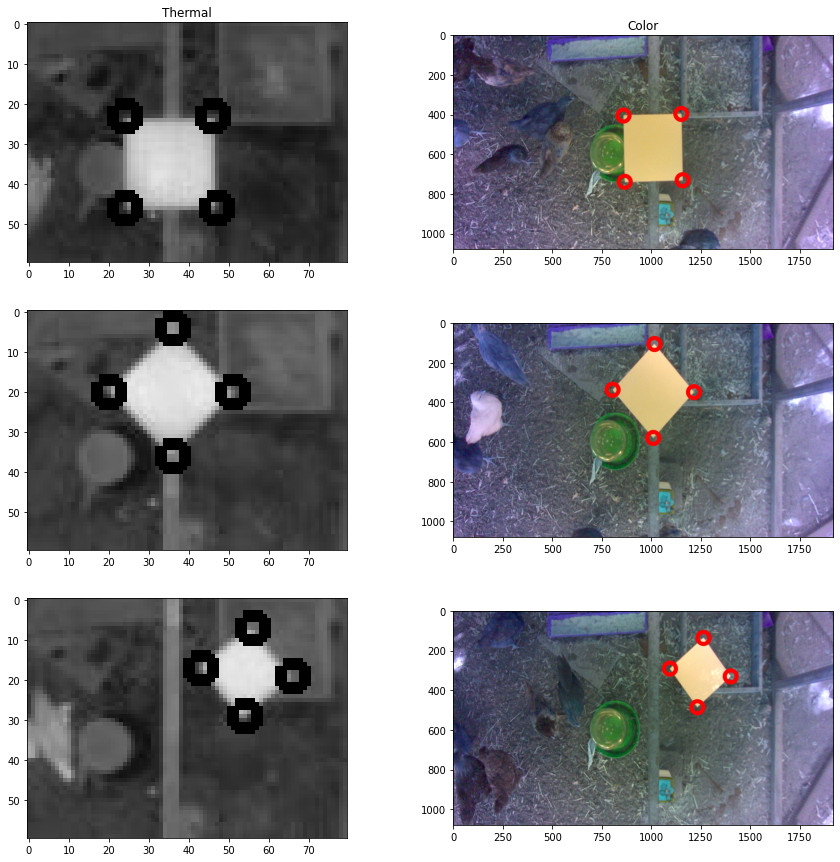

T_therm_color
 [[  0.078  -0.001 -42.77 ]
 [  0.      0.066  -3.441]
 [ -0.      0.      1.   ]] 

T_color_therm
 [[ 12.813   0.112 548.383]
 [ -0.077  15.103  48.662]
 [  0.      0.      1.   ]]
Stored 'T_color_therm' (ndarray)
Average reprojection error (pix): 9.5


In [6]:
%run extrinsic_calibration.ipynb

# Qualitative Behavior Analysis
One of the goals of this process is to be able to classify a chicken's behavior at a given time. Over the course of manual observation, the main behaviors were determined to be eating, drinking, roosting (in a nesting box, on the ground or on a perch), dust bathing, flying and walking/running.

In [86]:
display(Video.from_file('/home/ed/Documents/basic_behaviors_v2.mp4'))

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x01\x06\xdbmoov...')

# Underlying Data Structure
## Chicken Segmentation
Intuitively, living objects have a body temperature distinctly above the ambient temperature. The degree to which this may be used to segment animals from their background is not clear a priori, but it was clear after reviewing the footage that a simple intensity threshold leading to a binary mask could go a long way to segmenting individual chickens. 

The processing steps include:

(Thermal Image)
1. Blur to reduce noise
2. Apply threshold on image to generate binary mask
3. Apply morphological operations to reduce noise
4. Calculate contours of binary masks

(Color Image)
5. Calculate the bounding box surrounding each contour
6. Transform the bounding box to the color pixel space

In [77]:
def ros_to_cv2(msg, enc):
    return br.imgmsg_to_cv2(msg, enc)

In [78]:
blur_window = 3
intensity_threshold_body = 130 # 150, 130 was good
intensity_threshold_head = 190 # 150, 130 was good
kernel = np.ones((3,3),np.uint8)

def process_thermal(im, head=False):
    '''
    Convert from ROS to cv2 format
    Apply threshold on image to generate binary mask
    Apply morphological operations to reduce noise
    Calculate contours of binary masks
    Return the processed image, a list of contours and the mean pixel value of the original frame
    '''
    im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    mean = cv2.mean(im)
    im = cv2.blur(im, (blur_window, blur_window))
    if head:
        intensity_threshold = intensity_threshold_head
    else: 
        intensity_threshold = intensity_threshold_body      
    _, thresh = cv2.threshold(im, intensity_threshold, 255, cv2.THRESH_BINARY)
    erode = cv2.erode(thresh,kernel,iterations = 1)    
    dilate = cv2.dilate(erode,kernel,iterations = 1)
    contours = cv2.findContours(dilate, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[0]
    return dilate, contours, mean

def draw_contour_lines(im, contour):
    for i in range(len(contour)):
        if i == len(contour) - 1:
            im = cv2.line(im, (contour[i][0][0], contour[i][0][1]), (contour[0][0][0], contour[0][0][1]), (0, 255, 0))
        else: 
            im = cv2.line(im, (contour[i][0][0], contour[i][0][1]), (contour[i+1][0][0], contour[i+1][0][1]), (0, 255, 0))
    return im

In [79]:
wt = 80
ht = 60

times = []
average_areas = []
contours_therm = None
processed_therm = None
mean_therms = []
occ_hm = np.zeros((ht, wt))

# Transform boundary coords
# top left
res = np.dot(T_color_therm, np.array([0, 0, 1.0]))
res = [int(x) for x in res]
tl_corner = tuple(res[0:2])

# bottom right
res = np.dot(T_color_therm, np.array([wt, ht, 1.0]))
res = [int(x) for x in res]
br_corner = tuple(res[0:2])

def therm_clbk(msg):
    '''
    Process received image
    Calculate properties of blobs
    '''
    global contours_therm
    global processed_therm
    im_cv2 = ros_to_cv2(msg, 'mono8')
    im_cv2 = cv2.cvtColor(im_cv2, cv2.COLOR_GRAY2RGB)
    processed_therm, contours_therm, mean_therm = process_thermal(im_cv2, head=False)
    average_area = 0
    count = 1;
    for c in contours_therm:
        average_area += (cv2.contourArea(c) - average_area)/count;
        count += 1;   
        im_cv2 = draw_contour_lines(im_cv2, c)
    times.append(msg.header.stamp.secs)
    average_areas.append(average_area)
    mean_therms.append(mean_therm[0])
    therm_pub.publish(br.cv2_to_imgmsg(im_cv2, encoding='rgb8'))
    
def color_clbk(msg):
    global contours_therm
    global processed_therm
    im_cv2 = ros_to_cv2(msg, 'rgb8')
    size = im_cv2.shape
    mask = np.zeros((size[0], size[1]))
    if contours_therm is not None and processed_therm is not None:
        for c in contours_therm:
            rect = cv2.minAreaRect(c)
            box_t = cv2.boxPoints(rect)
            box_t = np.int0(box_t)
            box_c = []
            center_t = [0,0]
            count = 1
            for p in box_t:
                center_t[0] += (box_t[count-1][0] - center_t[0])/count
                center_t[1] += (box_t[count-1][1] - center_t[1])/count
                p = np.append(p, 1.0) # make homogeneous
                res = np.dot(T_color_therm, p)
                res = [int(x) for x in res]
                box_c.append(res[0:2])
                count += 1
            center_t = np.int0(center_t)
            occ_hm[center_t[1], center_t[0]] += 1
            box_c = np.array(box_c)
            cv2.drawContours(im_cv2, [box_c], 0,(0,255,0),5)
        im_cv2 = cv2.rectangle(im_cv2, tl_corner, br_corner, (255, 255, 0), 5)
        color_pub.publish(br.cv2_to_imgmsg(im_cv2, encoding='rgb8'))    

While the exact scale of the dataset is still up for debate, there is a likely need to annotate in the order of  thousands of frames over a few dozen sequences, each with multiple chickens in the frame. While this naive thresholding approach is not likely to be the complete solution to auto-generating labeled images, it is likely that it can generate bounding box proposals which can be refined by a human annotator.

In [81]:
# Listen to topics and play rosbag    
jr.subscribe("thermal/camera/image_raw_throttle", Image, therm_clbk)
jr.subscribe("color/camera/image_rect_color", Image, color_clbk)
with prb.BagPlayer("/home/ed/Data/2020-06-24-11-33-00_test/2020-06-24-11-49-00_4.bag") as example:
    example.play(publish_rate_multiplier=1.0, loop='false', start_time=115)
    while example.is_running:
        pass 

Removing previous callback, only one redirection possible right now
Removing previous callback, only one redirection possible right now


## Map Between Thermal and Color Frames
The following video shows that an approximate bounding box segmentation of chickens is possible by mapping the thermal detection into the corresponding color frame. In this sequence, the chickens have a relatively good level of physical separation from each other, which helps to demonstrate the best-case performance of this basic method. Note the occasional bounding box on the perching beam, which still shows the residual heat from a chicken that used to be sitting on it.

In [16]:
display(Video.from_file('/home/ed/Videos/bb_mapping.mp4'))

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free...')

The following plot shows a time series history of average blob areas over this period. This helps give some basis for what the size of a fully-separated individual is versus one whose mask is merged with another one. This data is confounded by the fact that multiple merges and splits can occur within seconds of each other, and that perching birds have a higher area as they are closer to the camera. Nonetheless, it demonstrates that a chicken's segmented area will range between 70-200 pixels.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0f833908>]],
      dtype=object)

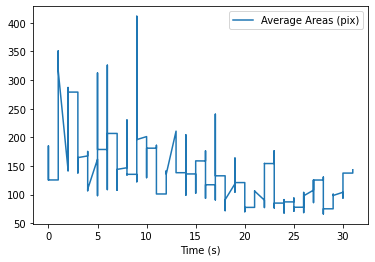

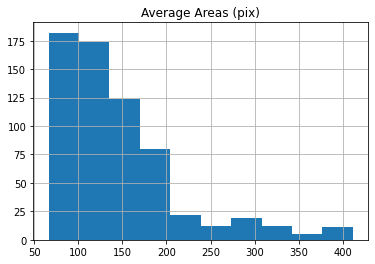

In [82]:
# Display filtered result of average blob size    
df = pd.DataFrame({'Time (s)': [x - times[0] for x in times], 'Average Areas (pix)': average_areas})
# b, a = butter(2, .5)
# df['Average Areas (pix)'] = filtfilt(b, a, df['Average Areas (pix)'])
df.plot(x='Time (s)', y='Average Areas (pix)')
df.hist('Average Areas (pix)')

## Relationship Between Image Modalities: Principal Component Analysis
A Principal Component Analysis (PCA) is carried out to ascertain the degree to which the thermal and color images provide different and complementary information. The results of this analysis will help justify the intuition that the results for detection and tracking using both modes will be richer than using each in isolation.

Eigenvalues: [2.781 0.93  0.218 0.072]


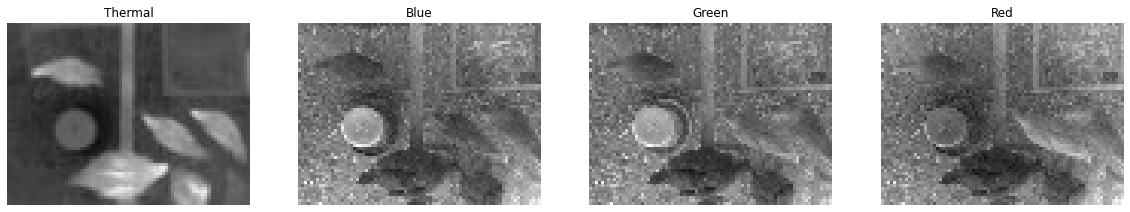

In [48]:
pca_therm_frame = cv2.imread('assets/pca_therm.jpg')
pca_color_frame = cv2.imread('assets/pca_color.jpg')

# Crop and resize color image to be same dimensions and field of view  as thermal image
pca_color_frame = pca_color_frame[tl_corner[1]:br_corner[1], tl_corner[0]:br_corner[0], :]
pca_color_frame = cv2.resize(pca_color_frame, (wt, ht))
bands = ['Thermal', 'Blue', 'Green', 'Red']
pcs = ['PC1', 'PC2', 'PC3', 'PC4']

# Segment out each channel
fig, axs = plt.subplots(1, 4, figsize=(20, 20))
pca_therm_frame = pca_therm_frame[:,:,0]
b = pca_color_frame[:,:,0]
g = pca_color_frame[:,:,1]
r = pca_color_frame[:,:,2]
frames = [pca_therm_frame, b, g, r]

# Show original frames
for i in range(len(frames)):
    axs[i].imshow(frames[i], cmap='gray', vmin=0, vmax=255)
    axs[i].axis('off')
    axs[i].set_title(bands[i])

# Normalize each channel's data
n_bands = 4
matrix = np.zeros((b.size, n_bands))
for i in range(n_bands):
    arr = frames[i].flatten()
    arr_std = (arr - arr.mean())/arr.std()
    matrix[:,i] = arr_std

# Do PCA
np.set_printoptions(precision=3)
cov = np.cov(matrix.transpose())
eigval, eigvec = np.linalg.eig(cov)
order = eigval.argsort()[::-1]
eigval = eigval[order]
eigvec = eigvec[:,order]
pc = np.matmul(matrix, eigvec)    
print('Eigenvalues:', eigval)

The following pair plots show the cross-correlation of the four image channels. As expected, there is no discernible correlation between the thermal image and any channel of the color image, whereas there is a clear linear correlation among each channel of the color image. This trait validates our assumption that the signal spaces are distinct.

Text(0.5, 0.98, 'Correlation matrix for thermal image and RGB channels of color image')

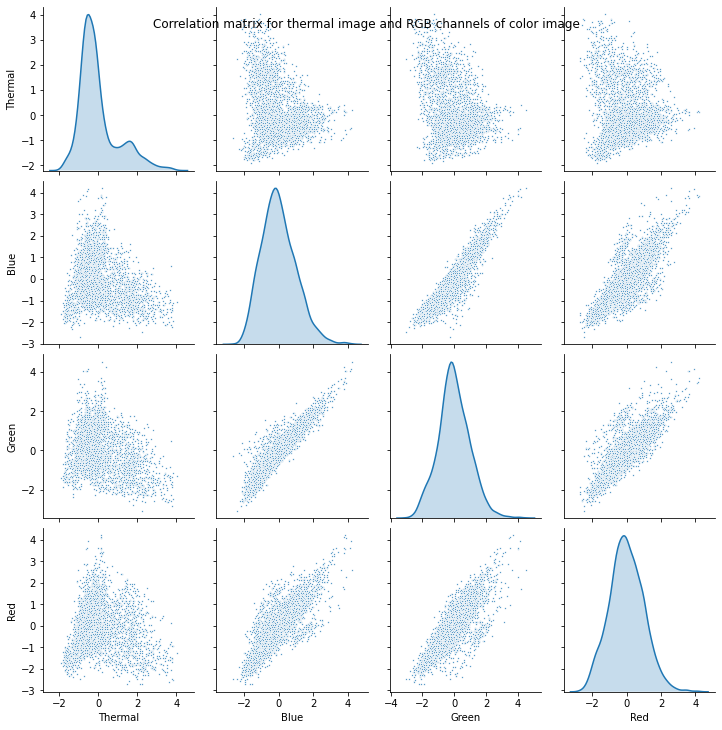

In [47]:
pp_orig = sns.pairplot(pd.DataFrame(matrix, columns=bands), diag_kind='kde', plot_kws={"s": 3})
pp_orig.fig.suptitle('Correlation matrix for thermal image and RGB channels of color image')

Text(0.5, 0.98, 'Correlation matrix for principal components after PCA')

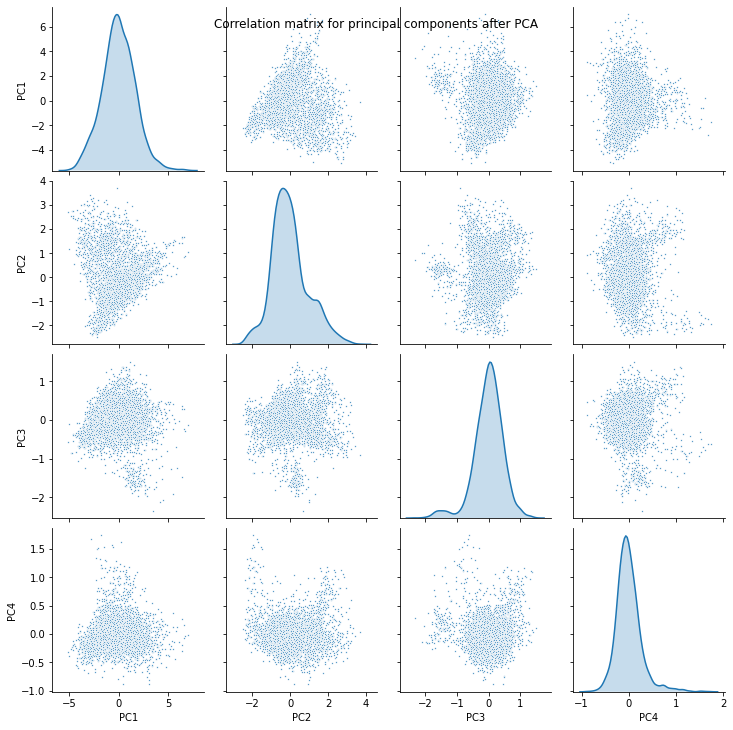

In [84]:
pp_pca = sns.pairplot(pd.DataFrame(pc, columns=pcs), diag_kind='kde', plot_kws={"s": 3})
pp_pca.fig.suptitle('Correlation matrix for principal components after PCA')

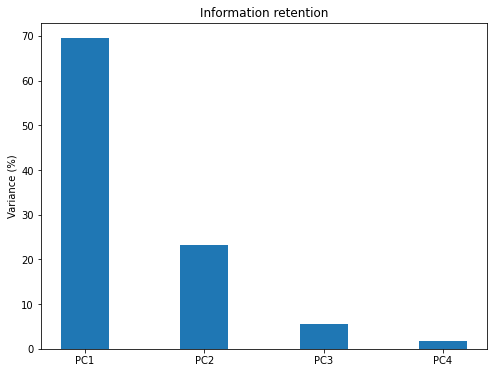

In [85]:
plt.figure(figsize=(8,6))
plt.bar([1,2,3,4],eigval/sum(eigval)*100,align='center',width=0.4, tick_label = pcs)
plt.ylabel('Variance (%)')
plt.title('Information retention');

Text(0.5, 1.0, 'Combination image of first three PCs')

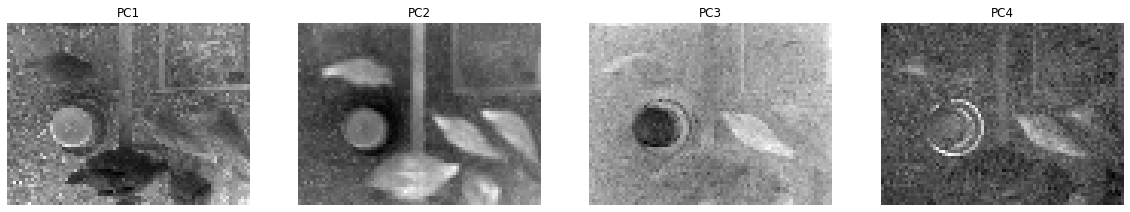

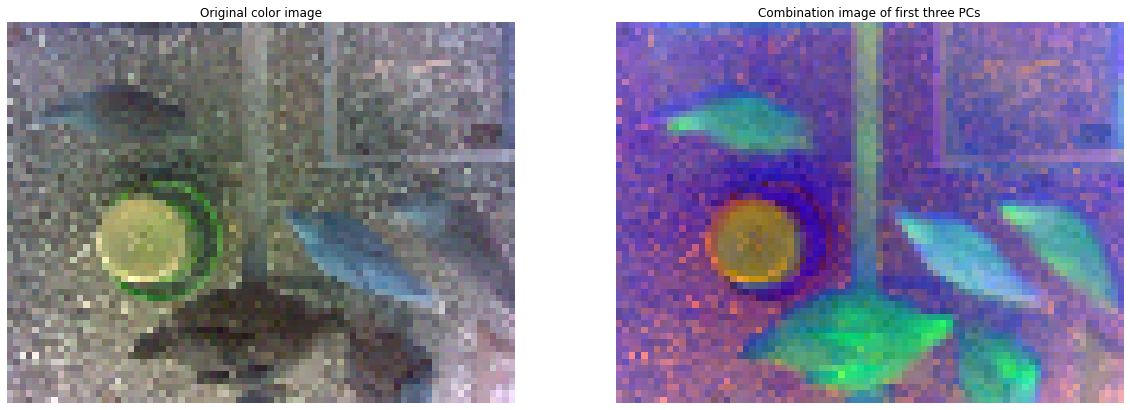

In [70]:
# Resize to 2D and scale back up to 0-255
pc2d = np.zeros((b.shape[0], b.shape[1], n_bands))
for i in range(n_bands):
    pc2d[:, :, i] = pc[:,i].reshape(-1, b.shape[1])
    pc2d[:, :, i] = cv2.normalize(pc2d[:, :, i], np.zeros(b.shape), 0, 255, cv2.NORM_MINMAX)

# Plot each component in image format    
figs, axes = plt.subplots(1, 4, figsize=(20,20))
for i in range(n_bands):
    axes[i].imshow(pc2d[:,:,i], cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(pcs[i])

# Compare original color image and combination of PCA images    
figs, axes = plt.subplots(1, 2, figsize=(20,20))
axes[0].imshow(pca_color_frame.astype(int))
axes[0].axis('off')
axes[0].set_title('Original color image')
axes[1].imshow(pc2d[:,:,:3].astype(int))
axes[1].axis('off')
axes[1].set_title('Combination image of first three PCs')

We now have a simple way of segmenting bodies, at least in the nominal condition where chickens are well separated. We can use this technique to extract more information about the individual chickens.

## Chicken Feather Color
We will want to be able to not just segment an individual chicken but also to uniquely identify it. Given that they look identical in the thermal spectrum, it is helpful to examine their appearance in the color spectrum. We will now present a histogram of chicken colors lying within a manually-drawn bounding box. In this way, we can proceed in this analysis without the need for a robust segmentation solution. 

Given we have a fixed number of chickens whose color will remain relatively stable over time, one possible approach for identifying them uniquely is to search for the nearest neighbor in the color space. As a preprocessing step for this exercise, we will convert from RGB to HSV space, which naturally affords higher contrast. 

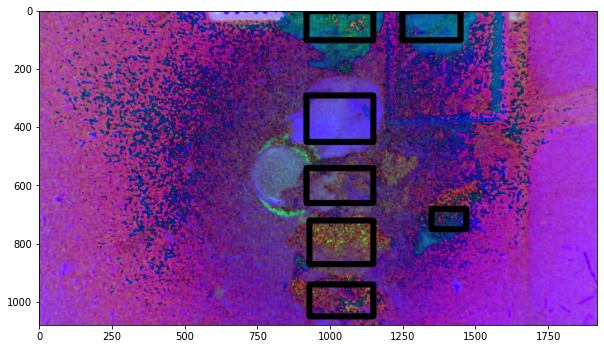

In [74]:
im = cv2.cvtColor(cv2.imread('assets/image_for_color_hist.jpg'), cv2.COLOR_BGR2HSV)
fig, ax = plt.subplots(figsize=(10, 10))

box_tl = [(920,0), (920, 290), (920, 540), (930, 720), (930,940), (1250,0), (1350,680)]
box_br = [(1150,100), (1150, 450), (1150, 660), (1150, 870), (1150, 1050), (1450,100), (1470,750)]
labels = ['brown', 'white', 'gray', 'black', 'black', 'brown', 'brown']
colors = []
for coord_tl, coord_br in zip(box_tl, box_br):
    im_disp = cv2.rectangle(im, coord_tl, coord_br, (0,0,0), 20)
    crop = im[coord_tl[1]:coord_br[1], coord_tl[0]:coord_br[0],:]
    crop = cv2.resize(crop, (10,10))
    colors.append(crop)
ax.imshow(im_disp)

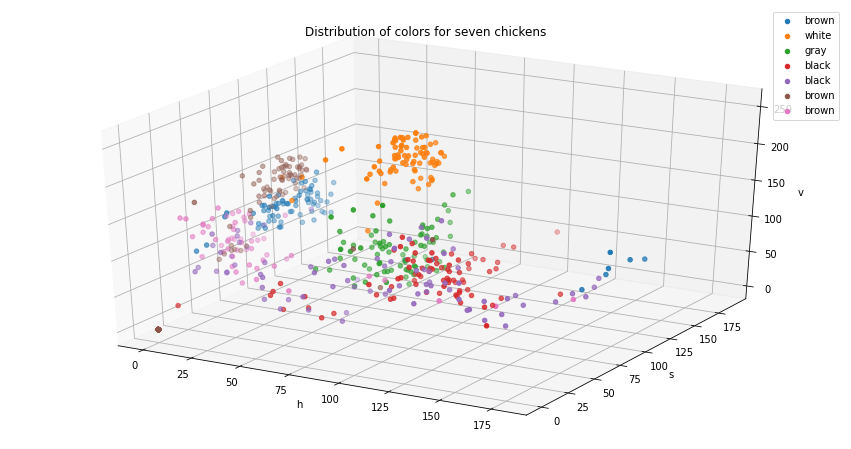

In [75]:
fig = plt.gcf()
fig.set_size_inches(15, 8)
ax = plt.axes(projection="3d")
for l, c in zip(labels, colors):
    h = c[:,:,0]
    s = c[:,:,1]
    v = c[:,:,2]
    ax.set_label(l)
    ax.scatter3D(h, s, v)

ax.set_xlabel('h')
ax.set_ylabel('s')
ax.set_zlabel('v')
ax.set_title('Distribution of colors for seven chickens')
plt.legend(labels)
plt.show()

## Chicken Orientation
We now have a basic technique for body segmentation which works quite well on well-separated bodies but breaks down when the bodies are close together. It is apparent that each chicken's head is warmer than its body, owing to the reduced feather coverage there. It is now worth examining how well a higher intensity threshold can identify heads, which can perhaps then be used to anchor a better estimate for body segmentation.
Alignment of the head with the principal axis of the bounding box. 

In [67]:
# When they are close to each other, they appear to merge in the thermal image

# Outlier and Anomaly Detection
## Thermal Camera Flat Field Correction
The thermal camera periodically undergoes a process known as [Flat Field Correction (FFC)](https://www.flir.com/support-center/oem/what-calibration-terms-are-applied-in-the-camera-there-is-the-ffc-and-also-the-gain-calibration.-are-there-others-can-i-do-my-own-calibration/). At arbitrary intervals, the shutter will move to cover the field of view provide a uniform surface for re-calibration if the camera's temperature fluctuates. The shutter itself is closed for less than 0.1s but the exposure takes some time (between 0.5s-5s) to adjust to the nominal levels. Its signature is a rapid, temporary increase in the average pixel intensity across the whole frame. If the approach is taken of segmenting bodies with a binary on the mask on the thermal image, it may be possible to account for this phenomenon by applying a low-pass filter over multiple frames to adaptively set this threshold or by simply ignoring observations until the frame returns to normal.

In [90]:
# Show an example of this phenomenon and plot the change of the average pixel intensity 
with prb.BagPlayer("/home/ed/Data/2020-06-13-14-00-00_test/high_fps/2020-06-13-14-41-09_0.bag") as example:
    example.play(publish_rate_multiplier=1.0, start_time=135)
    while example.is_running:
        pass    

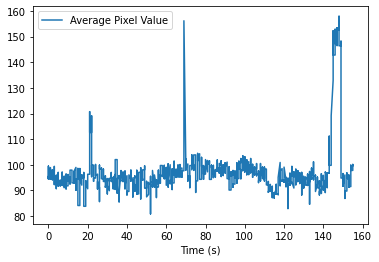

In [93]:
# Display average pixel value per frame
df = pd.DataFrame({'Time (s)': [x - times[0] for x in times], 'Average Pixel Value': mean_therms})
df.plot(x='Time (s)', y='Average Pixel Value')

## Occlusions
In this configuration, a chicken is commonly subject to some sort of occlusion, which has three potential sources:
1. Another chicken
2. An object in the coop such as the perching beam
3. (Either) camera's field of view

An example of each is shown below.

(-0.5, 1201.5, 404.5, -0.5)

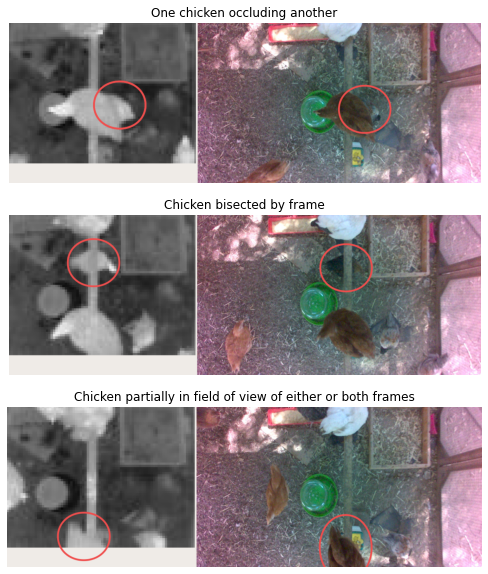

In [15]:
fig, axs = plt.subplots(3, 1, figsize=(20, 10))
axs[0].imshow(plt.imread('assets/occ1.png'))
axs[0].set_title('One chicken occluding another')
axs[0].axis('off')
axs[1].imshow(plt.imread('assets/occ2.png'))
axs[1].set_title('Chicken bisected by frame')
axs[1].axis('off')
axs[2].imshow(plt.imread('assets/occ3.png'))
axs[2].set_title('Chicken partially in field of view of either or both frames')
axs[2].axis('off')

# Potential Sources of Bias
There are three principal sources of bias originating from the data collection process:
1. The data collection runs typically are shorter than 30 minutes. Even after accounting for inactivity during the night, it is still less than 5% of the day's activity. One major assumption is that the distribution of activities and behaviors is consistent across the day. 
2. In this coop, less than 50% of the available floor space is covered by the field of view of both cameras combined. The field of view is primarily in open space, whereas the chickens prefer to spend most of their time in nooks and crannies, or perching. Therefore, the full range of behaviors may not be observable.
3. As the thermal camera normalizes its output automatically, data collected at different times throughout the day and from day to day will probably be different. 

# Image Processing Investigation
## Investigation of Quality of Downsampled Color Image
The color image is much larger than the thermal image and it is worthwhile to understand the degree of information loss if the color image were to be downscaled, if performance gains are required during training or inference. Note simplification made here where the color image is not initially cropped to match the thermal FOV before downscaling. 

Text(0.5, 1.0, 'Effect of downsampling ratio on pixel value error after upsampling a downsampled image')

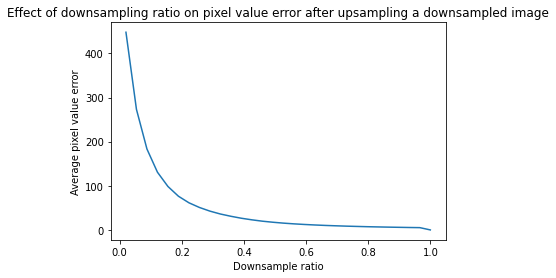

In [107]:
# Progressively downsample and then remap pixels to original to see deviation
num_ratios = 30
num_sample_frames = 5
resize_ratios = np.linspace(0.02, 1, num=num_ratios)
errs = []
im = cv2.imread('assets/compression_sample.jpg')
im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
therm_size_ratio = [im.shape[0]/60.0 * x for x in resize_ratios] # 60: thermal im height
sample_frames = []

for i, r in enumerate(resize_ratios):
    temp = cv2.resize(im, (int(im.shape[1]*r), int(im.shape[0]*r)))
    up = cv2.resize(temp, (int(im.shape[1]), int(im.shape[0])))
    # https://www.pyimagesearch.com/2014/09/15/python-compare-two-images/
    err = np.sum((up.astype("float") - im.astype("float")) ** 2)
    err /= float(im.shape[0] * im.shape[1])
    errs.append(err)
    if (i % (num_ratios/num_sample_frames) == 0):
        sample_frames.append(up)
    
plt.plot(resize_ratios, errs)
plt.xlabel('Downsample ratio')
plt.ylabel('Average pixel value error')
plt.title('Effect of downsampling ratio on pixel value error after upsampling a downsampled image')

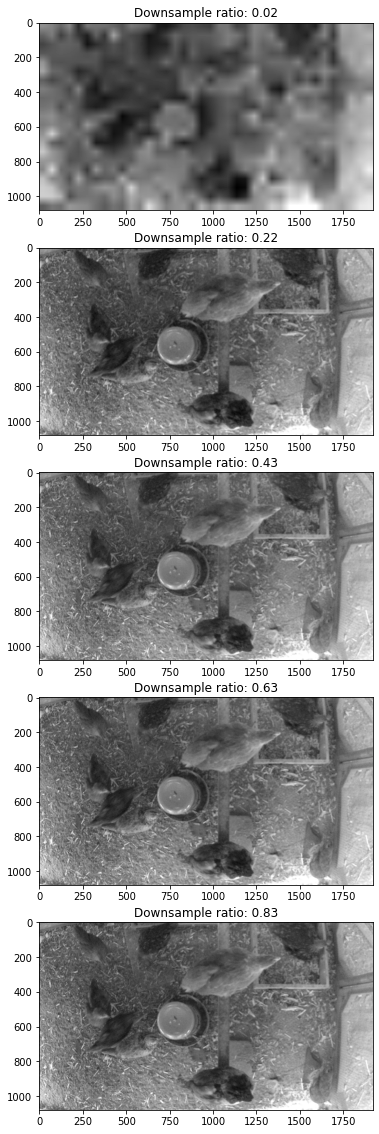

In [106]:
# Show the images after downsampling and re-upsampling
figs, axes = plt.subplots(num_sample_frames,1, figsize=(20,20))
for i in range(num_sample_frames):
    axes[i].imshow(sample_frames[i], cmap='gray')
    axes[i].title.set_text('{}{:.2f}'.format('Downsample ratio: ',resize_ratios[int(i * num_ratios/num_sample_frames)]))

After inspecting both the pixel error plot and the upsampled images, it appears the 'knee' of the curve of quality is around 20% scaling. In the image at this downsampling ratio, the borders of the chickens are still very distinct. This will be chosen as the downsampling ratio.

# Questions for Potential Future Exploration
## Experimental Setup
1. How sensitive is the performance of thermal segmentation to the ambient conditions, including temperature and sunlight penetration?
2. Is it possible to use a smaller number of chickens, which are very distinct from each other in appearance, to simplify the tracking task?
3. How can the environment be simplified to maximize the contast of the chickens against the background?

## Image Processing
1. How much could background subtraction improve segmentation performance? Is it a worthwhile preprocessing step?
2. What are the effects of the frame rate on tracking performance?
3. What improvement in tracking performance is available if the full field of the color camera is used, even if thermal data is not available there?
4. How much can the color image be downsampled before performance starts to degrade significantly?

## Modeling
1. What are the implications of using either a frame-aligned bounding box, an oriented bounding box or an ellipse for object detection?

## Behavior Analysis
1. How much has a given chicken eaten, drunk and moved over the course of a day?
2. Is every chicken present?
3. What is the structure of the social groups?